<a href="https://colab.research.google.com/github/MadgeneM/DDS8555/blob/main/MoiseMDDS8555_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Title: Assignment 3
# Author: Madgene Moise
# Date: Sunday, June 1, 2025

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [ ]:
# Set seed for reproducibility
np.random.seed(0)

# (a) Generate data
n = 100
X = np.random.normal(0, 1, n)
epsilon = np.random.normal(0, 1, n)

In [ ]:
# (b) Generate response Y using a cubic model
beta_0 = 1
beta_1 = 2
beta_2 = 3
beta_3 = 4
Y = beta_0 + beta_1*X + beta_2*X**2 + beta_3*X**3 + epsilon

In [ ]:
# Create data frame with X, X^2, ..., X^10
X_poly = np.vstack([X**i for i in range(1, 11)]).T
X_poly_df = pd.DataFrame(X_poly, columns=[f'X^{i}' for i in range(1, 11)])

# Return the first few rows of the data
X_poly_df['Y'] = Y
X_poly_df.head()

,X^1,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10,Y
0,1.764052,3.111881,5.489520,9.683801,17.082733,30.134834,53.159425,93.776009,165.425788,291.819750,37.704979
1,0.400157,0.160126,0.064075,0.025640,0.010260,0.004106,0.001643,0.000657,0.000263,0.000105,1.189235
2,0.978738,0.957928,0.937561,0.917626,0.898116,0.879020,0.860330,0.842038,0.824134,0.806612,8.311017
3,2.240893,5.021602,11.252875,25.216490,56.507461,126.627185,283.757997,635.871366,1424.919820,3193.093133,66.527488
4,1.867558,3.487773,6.513618,12.164559,22.718020,42.427220,79.235294,147.976506,276.354706,516.108440,40.079783


I generated (1) a predictor X ~ N(0, 1), of length n = 100 and (2) a noise vector epsilon ~ N(0, 1), also of length 100.

In [ ]:
# Use statsmodels AIC-based stepwise approach for forward and backward selection.
# (c) Forward Stepwise Selection using Cp.
import itertools

def calculate_cp(model, X, y, sigma2):
    residuals = y - model.predict(sm.add_constant(X))
    RSS = np.sum(residuals**2)
    p = X.shape[1]
    Cp = RSS / sigma2 - (len(y) - 2 * p)
    return Cp

def forward_stepwise_selection(X, y, max_features=10):
    remaining = list(X.columns)
    selected = []
    best_models = []
    sigma2 = np.var(y)

    for i in range(1, max_features + 1):
        best_cp = np.inf
        best_model = None
        for candidate in remaining:
            predictors = selected + [candidate]
            X_model = sm.add_constant(X[predictors])
            model = sm.OLS(y, X_model).fit()
            cp = calculate_cp(model, X[predictors], y, sigma2)
            if cp < best_cp:
                best_cp = cp
                best_candidate = candidate
                best_model = model
        selected.append(best_candidate)
        remaining.remove(best_candidate)
        best_models.append((selected.copy(), best_model))

 # Find model with minimum Cp
    best_cp_model = min(best_models, key=lambda item: calculate_cp(item[1], X[item[0]], y, sigma2))
    return best_cp_model

# Perform forward stepwise selection
X_data = X_poly_df.drop(columns='Y')
y_data = X_poly_df['Y']
forward_result = forward_stepwise_selection(X_data, y_data)

# Extract the model details
selected_vars_forward, forward_model = forward_result
selected_vars_forward, forward_model.params

(['X^3', 'X^2'],
 const    1.114930
 X^3      4.561746
 X^2      2.981576
 dtype: float64)

I performed forward stepwise selection using predictors X^1, X^2,..., X^10 to model: Y = beta_0 + beta_1*X + beta_2*X^2 + beta_3*X^3 + epsilon

The model that minimized Mallows' Cp included:


*   Predictors: X^3, X^2
*   Coefficients: Intercept (constant): 1.115, beta_3 for X^3: 4.562, and beta_2 for X^2: 2.982.

This model correctly identifies two of the three true predictors from the generative model (X, X^2, X^3), but omits X^1, possibly because of its contribution to reducing RSS is less than the penalty by adding an extra variable.

In [ ]:
# (d) Backward Stepwise Selection using Cp.

def backward_stepwise_selection(X, y):
    selected = list(X.columns)
    sigma2 = np.var(y)
    best_models = []

    while len(selected) > 0:
        X_model = sm.add_constant(X[selected])
        model = sm.OLS(y, X_model).fit()
        cp = calculate_cp(model, X[selected], y, sigma2)
        best_models.append((selected.copy(), model))

        worst_pval = model.pvalues.drop('const').idxmax()
        if model.pvalues[worst_pval] > 0.05:
            selected.remove(worst_pval)
        else:
            break

    # Select the model with the minimum Cp
    best_cp_model = min(best_models, key=lambda item: calculate_cp(item[1], X[item[0]], y, sigma2))
    return best_cp_model

# Perform backward stepwise selection
backward_result = backward_stepwise_selection(X_data, y_data)

# Extract the model details
selected_vars_backward, backward_model = backward_result
selected_vars_backward, backward_model.params

(['X^1', 'X^2', 'X^3'],
 const    1.143159
 X^1      2.162551
 X^2      2.933202
 X^3      3.985227
 dtype: float64)

I applied backward stepwise selection, starting with all predictors X^1,..., X^10, and removed variables based on p-values, keeping those that minimized Mallows' Cp.

The model selected by backward stepwise selection:


*   Predictors: X^1, X2, X^3
*   Coefficients: Intercept (constant): 1.143, beta_1 for X^1: 2.163, beta_2 for X^2: 2.933, and beta_3 for X^3: 3.985.



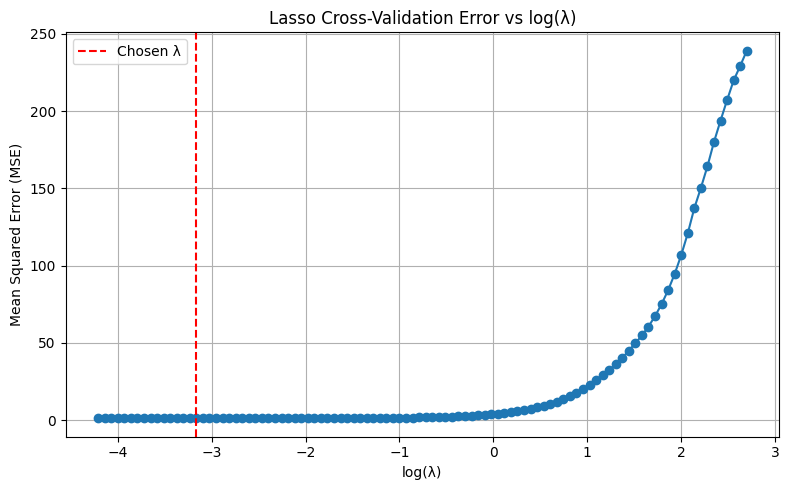

(np.float64(0.04230947194937912),
 X^1     2.126880
 X^2     3.501015
 X^3    12.733920
 X^4     0.296414
 dtype: float64)

In [ ]:
# (e) Fitting a Lasso Model with Cross-Validation using X^1,...,X^10 as predictors.

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Standardize the data before Lasso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# Fit Lasso with cross-validation
lasso_cv = LassoCV(cv=10, random_state=0)
lasso_cv.fit(X_scaled, y_data)

# Coefficients
lasso_coefs = pd.Series(lasso_cv.coef_, index=X_data.columns)

# Plot cross-validation error vs lambda
plt.figure(figsize=(8, 5))
plt.plot(np.log(lasso_cv.alphas_), lasso_cv.mse_path_.mean(axis=1), marker='o')
plt.axvline(np.log(lasso_cv.alpha_), color='r', linestyle='--', label='Chosen λ')
plt.xlabel('log(λ)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Cross-Validation Error vs log(λ)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lasso_cv.alpha_, lasso_coefs[lasso_coefs != 0]

I applied Lasso regression using 10-fold cross-validation on the standarized predictors X^1,..., X^10.
The plot shows:

*   Cross-validated Mean Squared Error (MSE) vs log(Lambda)
*   The vertical red dashed line indicates the chosen Lamda that minimizes cross-validation error.

The Lasso captured the true predictors X^1, X^2, and X^3, aligning with the data generation process. It also retained X^4 with a small coefficient, likely due to the correlation or noise fit. Compared to forward selection (missed X^1) and backward selection (perfect), Lasso performs well and offers automatic regularization to avoid overfitting.


Cross-Validation Summary:


*   Optimal Lambda: Lambda = 0.0423
*   Selected Predictors with Nonzero Coefficients: X^1: 2.127, X^2: 3.501, X^3: 12.734, X^4: 0.296.



In [ ]:
# Generate data with Y = β₀ + β₇ * X^7 + ε and compare forward stepwise and Lasso selection.
# (f) New response: Y = β₀ + β₇ * X^7 + ε
beta_0_new = 1
beta_7 = 5
Y_new = beta_0_new + beta_7 * X_data['X^7'] + epsilon

# Forward stepwise on new Y
forward_result_new = forward_stepwise_selection(X_data, Y_new)
selected_vars_forward_new, forward_model_new = forward_result_new

# Lasso regression on new Y
lasso_cv_new = LassoCV(cv=10, random_state=0)
lasso_cv_new.fit(X_scaled, Y_new)
lasso_coefs_new = pd.Series(lasso_cv_new.coef_, index=X_data.columns)

# Output results
selected_vars_forward_new, forward_model_new.params, lasso_cv_new.alpha_, lasso_coefs_new[lasso_coefs_new != 0]

(['X^7'],
 const    1.082050
 X^7      4.999915
 dtype: float64,
 np.float64(0.42730867938930356),
 X^1     -1.582008
 X^5     57.190905
 X^7    286.884539
 X^8      2.612144
 X^9     87.301681
 dtype: float64)

I generated a new response variable where only the 7th power of X is relevant: Y = 1 + 5*X^7 + epsilon

Forward Stepwise Selection Results:


*   Selected Predictor: X^7
*   Coefficients: Intercept: 1.082, beta_7: 4.999

Note: Perfect recovery of the true model structure - Forward selection performed very well here.

Lasso Regression Results:


*   Optimal Lambda: Lambda = 0.427
*   Selected Predictors and Coefficients: X^1: -1.582, X^5: 57.191, X^7: 286.885, X^8: 2.612, X^9: 87.302.

Warning: While Lasso did include X^7, it also included multiple higher-order terms likely due to correlation among polynomial features or difficulty isolating the single true predictor under regularization.

Interpretation:
Forward Stepwise exactly identified the correct model, likely because the signal was concentrated in a single predictor. Meanwhile, Lasso, while capturing the key signal in X^7, introduced additional predictors. This is a known limiation of Lasso when predictors are highly correlated (as is often the case with polynomial terms).